In [10]:
import kagglehub
ninadaithal_imagesoasis_path = kagglehub.dataset_download('ninadaithal/imagesoasis')

print('Data source import complete.')


Using Colab cache for faster access to the 'imagesoasis' dataset.
Data source import complete.


In [11]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Streaming output truncated to the last 5000 lines.
/kaggle/input/imagesoasis/Data/Mild Dementia/OAS1_0316_MR1_mpr-2_127.jpg
/kaggle/input/imagesoasis/Data/Mild Dementia/OAS1_0053_MR1_mpr-2_107.jpg
/kaggle/input/imagesoasis/Data/Mild Dementia/OAS1_0382_MR1_mpr-1_154.jpg
/kaggle/input/imagesoasis/Data/Mild Dementia/OAS1_0056_MR1_mpr-2_141.jpg
/kaggle/input/imagesoasis/Data/Mild Dementia/OAS1_0067_MR1_mpr-1_137.jpg
/kaggle/input/imagesoasis/Data/Mild Dementia/OAS1_0031_MR1_mpr-3_117.jpg
/kaggle/input/imagesoasis/Data/Mild Dementia/OAS1_0291_MR1_mpr-1_113.jpg
/kaggle/input/imagesoasis/Data/Mild Dementia/OAS1_0373_MR1_mpr-2_138.jpg
/kaggle/input/imagesoasis/Data/Mild Dementia/OAS1_0073_MR1_mpr-4_146.jpg
/kaggle/input/imagesoasis/Data/Mild Dementia/OAS1_0073_MR1_mpr-3_122.jpg
/kaggle/input/imagesoasis/Data/Mild Dementia/OAS1_0291_MR1_mpr-1_124.jpg
/kaggle/input/imagesoasis/Data/Mild Dementia/OAS1_0268_MR1_mpr-2_116.jpg
/kaggle/input/imagesoasis/Data/Mild Dementia/OAS1_0184_MR1_mpr-4_108.jpg


In [ ]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

In [ ]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [8]:
""""
# Parameters
DATA_DIR = '/kaggle/input/imagesoasis/Data'  # Update this path if necessary
CLASSES = ['Non Demented', 'Very mild Dementia', 'Mild Dementia', 'Moderate Dementia']
SAMPLES_PER_CLASS_MAIN = 4500
SAMPLES_PER_CLASS_ADDITIONAL = 450
IMG_SIZE = 299
BATCH_SIZE = 32
EPOCHS = 20
""""""""""""

SyntaxError: incomplete input (ipython-input-2736718478.py, line 10)

In [14]:
import tensorflow as tf

DATA_DIR = '/kaggle/input/imagesoasis/Data'
SAMPLES_PER_CLASS_MAIN = 2500
SAMPLES_PER_CLASS_ADDITIONAL = 450
IMG_SIZE = 299
BATCH_SIZE = 32
EPOCHS = 20
VAL_SPLIT = 0.2
RNG_SEED = 1337

from pathlib import Path
import numpy as np
import os

# ---- Helper: اجمع الصور لكل فئة (يدعم تطابق غير حساس لحالة الأحرف) ----
IMG_EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff'}

def gather_class_images(data_dir, class_name):
    base = Path(data_dir)
    candidates = []

    exact = base / class_name
    if exact.exists():
        candidates.append(exact)
    else:
        # جرّب مطابقات مباشرة تحت DATA_DIR
        for p in base.iterdir():
            if p.is_dir() and p.name.casefold() == class_name.casefold():
                candidates.append(p)

    imgs = []
    for d in candidates:
        for p in d.rglob('*'):
            if p.is_file() and p.suffix.lower() in IMG_EXTS:
                imgs.append(str(p))
    return imgs

# ---- دمج Mild + Moderate في فئة واحدة ----
class_map = {
    'Non Demented':            'Non Demented',
    'Very mild Dementia':      'Very mild Dementia',
    'Mild Dementia':           'Mild+Moderate Dementia',
    'Moderate Dementia':       'Mild+Moderate Dementia',
}

# اجمع الصور بعد الدمج
merged_images = {}
for src, dst in class_map.items():
    imgs = gather_class_images(DATA_DIR, src)
    merged_images.setdefault(dst, []).extend(imgs)

# إزالة التكرارات داخل كل فئة مدموجة
for dst in merged_images:
    merged_images[dst] = sorted(set(merged_images[dst]))

# ---- سحب العيّنات: لا تكرار في additional، مسموح بالتكرار في main فقط عند الحاجة ----
rng = np.random.default_rng(RNG_SEED)

image_paths_main, labels_main = [], []
image_paths_additional, labels_additional = [], []

for label, imgs in merged_images.items():
    n_unique = len(imgs)
    if n_unique == 0:
        print(f"Warning: no images for class '{label}'. Skipping.")
        continue

    # أولاً: خذ additional من صور فريدة بدون تكرار
    add_n = min(SAMPLES_PER_CLASS_ADDITIONAL, n_unique)
    add_idx = rng.choice(n_unique, size=add_n, replace=False)
    add_imgs = [imgs[i] for i in add_idx]

    # المتبقي للتدريب
    remaining = [imgs[i] for i in range(n_unique) if i not in set(add_idx)]
    rem_n = len(remaining)

    # ثانياً: خذ main؛ لو ما يكفي، كرّر من remaining (أو من imgs لو remaining صفر)
    main_needed = SAMPLES_PER_CLASS_MAIN
    if rem_n >= main_needed:
        main_idx = rng.choice(rem_n, size=main_needed, replace=False)
        main_imgs = [remaining[i] for i in main_idx]
    else:
        main_imgs = remaining.copy()
        deficit = main_needed - rem_n
        pool = remaining if rem_n > 0 else imgs  # تجنّب استخدام additional قدر الإمكان
        extra = list(rng.choice(pool, size=deficit, replace=True))
        main_imgs.extend(extra)

    # تراصيف نهائية
    image_paths_additional.extend(add_imgs)
    labels_additional.extend([label] * len(add_imgs))
    image_paths_main.extend(main_imgs)
    labels_main.extend([label] * len(main_imgs))

# ---- تقارير سريعة ----
import pandas as pd
df_train = pd.DataFrame({'image': image_paths_main, 'label': labels_main})
df_add   = pd.DataFrame({'image': image_paths_additional, 'label': labels_additional})

print("Train counts:")
print(df_train['label'].value_counts().to_string())
print("\nAdditional counts (no oversampling):")
print(df_add['label'].value_counts().to_string())

# ملاحظة: فئاتك الآن = 3 فقط
CLASSES_MERGED = ['Non Demented', 'Very mild Dementia', 'Mild+Moderate Dementia']


Train counts:
label
Non Demented              2500
Very mild Dementia        2500
Mild+Moderate Dementia    2500

Additional counts (no oversampling):
label
Non Demented              450
Very mild Dementia        450
Mild+Moderate Dementia    450
Train counts:
label
Non Demented              2500
Very mild Dementia        2500
Mild+Moderate Dementia    2500

Additional counts (no oversampling):
label
Non Demented              450
Very mild Dementia        450
Mild+Moderate Dementia    450


In [ ]:

"""""
def sample_images(data_dir, classes, samples_main, samples_additional):
    image_paths_main = []
    labels_main = []
    image_paths_additional = []
    labels_additional = []

    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: Directory not found: {class_dir}. Skipping this class.")
            continue
        all_class_images = [
            os.path.join(root, f)
            for root, _, files in os.walk(class_dir)
            for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))
        ]
        random.shuffle(all_class_images)

        if len(all_class_images) < samples_main + samples_additional:
            raise ValueError(f"Not enough images in {class_name}. Found {len(all_class_images)}, need {samples_main + samples_additional}.")

        sampled_main = all_class_images[:samples_main]
        sampled_additional = all_class_images[samples_main:samples_main + samples_additional]

        image_paths_main.extend(sampled_main)
        labels_main.extend([class_name]*len(sampled_main))

        image_paths_additional.extend(sampled_additional)
        labels_additional.extend([class_name]*len(sampled_additional))

    return image_paths_main, labels_main, image_paths_additional, labels_additional

image_paths_main, labels_main, image_paths_additional, labels_additional = sample_images(
    DATA_DIR, CLASSES, SAMPLES_PER_CLASS_MAIN, SAMPLES_PER_CLASS_ADDITIONAL
)
""""""

In [ ]:
print("\nImages sampled per class for main dataset:")
for cls in CLASSES_MERGED:
    count = sum(1 for l in labels_main if l == cls)
    print(f"{cls}: {count}")

print("\nImages sampled per class for additional testing:")
for cls in CLASSES_MERGED:
    count = sum(1 for l in labels_additional if l == cls)
    print(f"{cls}: {count}")


In [32]:
print("\nImages sampled per class for main dataset:")
for cls in CLASSES_MERGED:
    count = sum(1 for l in labels_main if l == cls)
    print(f"{cls}: {count}")

print("\nImages sampled per class for additional testing:")
for cls in CLASSES_MERGED:
    count = sum(1 for l in labels_additional if l == cls)
    print(f"{cls}: {count}")



Images sampled per class for main dataset:
Non Demented: 2500
Very mild Dementia: 2500
Mild+Moderate Dementia: 2500

Images sampled per class for additional testing:
Non Demented: 450
Very mild Dementia: 450
Mild+Moderate Dementia: 450


In [33]:
def load_and_preprocess(img_path, img_size=IMG_SIZE):
    try:
        img = Image.open(img_path).convert('RGB')
        img = img.resize((img_size, img_size))
        img = np.array(img)
        img = tf.keras.applications.inception_resnet_v2.preprocess_input(img)
        return img
    except Exception as e:
        print(f"Error loading image {img_path}: {e}")
        return None

In [34]:
# Load and preprocess main dataset
X_main = []
valid_image_paths_main = []
for path in tqdm(image_paths_main, desc="Loading main images"):
    img = load_and_preprocess(path)
    if img is not None:
        X_main.append(img)
        valid_image_paths_main.append(path)
X_main = np.array(X_main)
print("\nMain X shape:", X_main.shape)

Loading main images: 100%|██████████| 7500/7500 [00:37<00:00, 201.90it/s]



Main X shape: (7500, 299, 299, 3)


In [18]:
# Load and preprocess additional testing dataset
X_additional = []
valid_image_paths_additional = []
for path in tqdm(image_paths_additional, desc="Loading additional test images"):
    img = load_and_preprocess(path)
    if img is not None:
        X_additional.append(img)
        valid_image_paths_additional.append(path)
X_additional = np.array(X_additional)
print("Additional X shape:", X_additional.shape)

Loading additional test images: 100%|██████████| 1350/1350 [00:14<00:00, 92.77it/s]



Additional X shape: (1350, 299, 299, 3)
Additional X shape: (1350, 299, 299, 3)


In [28]:
# Encode main labels
label_encoder = LabelEncoder()
y_int_main = label_encoder.fit_transform(labels_main)
# One-hot encode
y_int_main = y_int_main.reshape(-1,1)
ohe = OneHotEncoder(sparse_output=False)  # تغيير sparse إلى sparse_output
y_main = ohe.fit_transform(y_int_main)
print("\nMain y shape:", y_main.shape)
print("Classes:", label_encoder.classes_)


Main y shape: (7500, 3)
Classes: ['Mild+Moderate Dementia' 'Non Demented' 'Very mild Dementia']


In [29]:
# Encode additional labels
y_int_additional = label_encoder.transform(labels_additional)
y_int_additional = y_int_additional.reshape(-1,1)
y_additional = ohe.transform(y_int_additional)
print("Additional y shape:", y_additional.shape)

Additional y shape: (1350, 3)


In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X_main, y_main, test_size=0.2, random_state=SEED, stratify=y_main
)

print(f"\nTraining samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")

# Further split training data into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=SEED, stratify=y_train
)

print(f"Validation samples: {X_val.shape[0]}")


Training samples: 6000
Testing samples: 1500
Validation samples: 600


In [35]:
y_train_labels = np.argmax(y_train, axis=1)
class_weights_values = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights_dict = dict(enumerate(class_weights_values))
print(f"\nClass Weights: {class_weights_dict}")


Class Weights: {0: np.float64(1.0), 1: np.float64(1.0), 2: np.float64(1.0)}


In [37]:
from tensorflow.keras import mixed_precision

# تفعيل mixed precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# ثم أعد بناء النموذج

In [38]:
base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)  # Added BatchNormalization
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)  # Added another Dense layer
x = Dropout(0.5)(x)
predictions = Dense(len(CLASSES_MERGED), activation='softmax')(x)

# Define the complete model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with Adam optimizer and initial learning rate
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_203 (Conv2D) │ (None, 149, 149,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_203[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_203      │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_204 (Conv2D) │ (None, 147, 147,  │      9,216 │ activation_203[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_204[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_204      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_205 (Conv2D) │ (None, 147, 147,  │     18,432 │ activation_204[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_205[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_205      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 73, 73,    │          0 │ activation_205[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_206 (Conv2D) │ (None, 73, 73,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_206[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_206      │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_207 (Conv2D) │ (None, 71, 71,    │    138,240 │ activation_206[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_207[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_207      │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 56,573,667 (215.81 MB)

 Trainable params: 2,233,859 (8.52 MB)

 Non-trainable params: 54,339,808 (207.29 MB)

In [39]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [ ]:
import torch

# التحقق من الجهاز المتاح
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple Silicon
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU
else:
    device = torch.device("cpu")  # CPU

print("device:", device)

In [40]:
from tensorflow.image import resize

def quick_resize(X_data):
    return tf.image.resize(X_data, [299, 299]).numpy()

print("تغيير حجم البيانات إلى 299x299...")
X_train = quick_resize(X_train)
X_val = quick_resize(X_val)
X_test = quick_resize(X_test) if 'X_test' in locals() else X_val

print(f"✅ تم تغيير الحجم:")
print(f"   X_train: {X_train.shape}")
print(f"   X_val: {X_val.shape}")

# الآن جرب التدريب
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=16,
    callbacks=[early_stop, checkpoint, reduce_lr]
)

تغيير حجم البيانات إلى 299x299...
✅ تم تغيير الحجم:
   X_train: (5400, 299, 299, 3)
   X_val: (600, 299, 299, 3)
Epoch 1/20
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4022 - loss: 1.5317
Epoch 1: val_loss improved from inf to 0.89964, saving model to best_model.keras
338/338 ━━━━━━━━━━━━━━━━━━━━ 90s 157ms/step - accuracy: 0.4023 - loss: 1.5311 - val_accuracy: 0.6100 - val_loss: 0.8996 - learning_rate: 1.0000e-04
Epoch 2/20
337/338 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5096 - loss: 1.0670
Epoch 2: val_loss improved from 0.89964 to 0.80201, saving model to best_model.keras
338/338 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.5097 - loss: 1.0667 - val_accuracy: 0.6517 - val_loss: 0.8020 - learning_rate: 1.0000e-04
Epoch 3/20
336/338 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5660 - loss: 0.9300
Epoch 3: val_loss improved from 0.80201 to 0.74243, saving model to best_model.keras
338/338 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.5662 - loss: 0.9297 - v

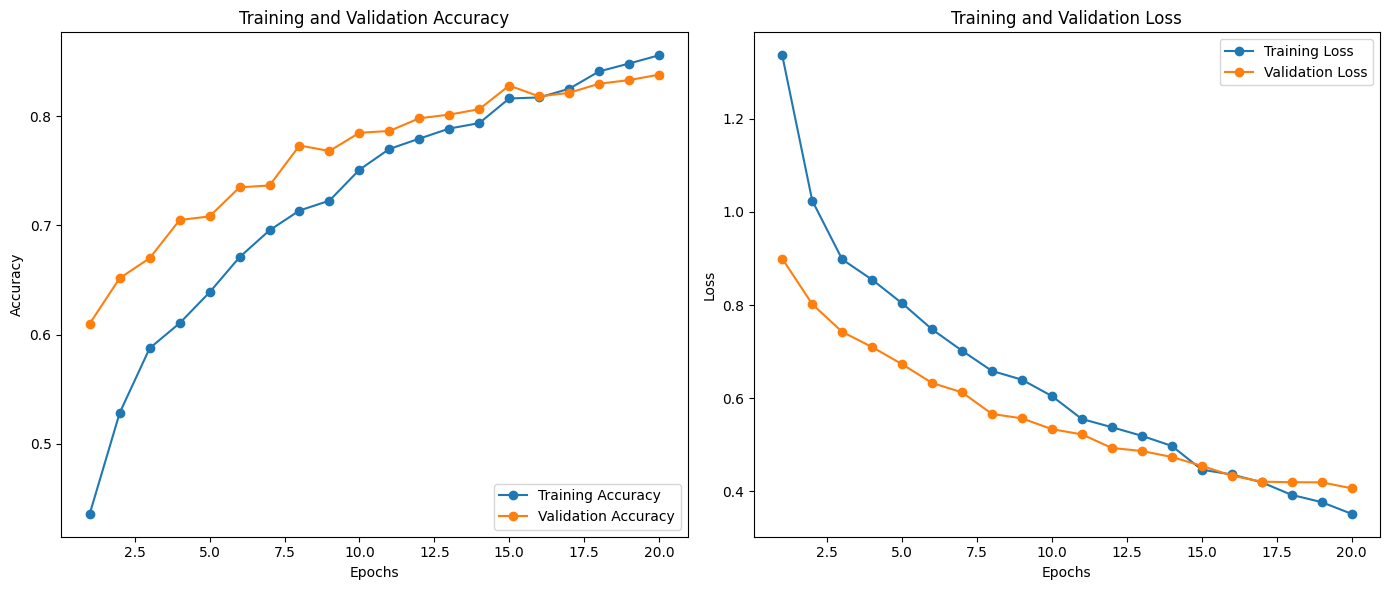

In [41]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', marker='o')
    plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

plot_history(history)

In [42]:
# Unfreeze some layers of the base model for fine-tuning
base_model.trainable = True

# Let's unfreeze the top 100 layers
for layer in base_model.layers[:-100]:
    layer.trainable = False

# Recompile the model with a lower learning rate
optimizer_fine = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer_fine,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_203 (Conv2D) │ (None, 149, 149,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_203[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_203      │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_204 (Conv2D) │ (None, 147, 147,  │      9,216 │ activation_203[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_204[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_204      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_205 (Conv2D) │ (None, 147, 147,  │     18,432 │ activation_204[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_205[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_205      │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 73, 73,    │          0 │ activation_205[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_206 (Conv2D) │ (None, 73, 73,    │      5,120 │ max_pooling2d_4[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_206[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_206      │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_207 (Conv2D) │ (None, 71, 71,    │    138,240 │ activation_206[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_207[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_207      │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 56,573,667 (215.81 MB)

 Trainable params: 17,637,635 (67.28 MB)

 Non-trainable params: 38,936,032 (148.53 MB)

In [43]:
fine_tune_history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop, checkpoint, reduce_lr],
    class_weight=class_weights_dict,
    shuffle=True
)

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.6989 - loss: 0.7846
Epoch 1: val_loss did not improve from 0.40665
169/169 ━━━━━━━━━━━━━━━━━━━━ 122s 385ms/step - accuracy: 0.6991 - loss: 0.7839 - val_accuracy: 0.8133 - val_loss: 0.4551 - learning_rate: 1.0000e-05
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8330 - loss: 0.4150
Epoch 2: val_loss did not improve from 0.40665
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.8330 - loss: 0.4149 - val_accuracy: 0.8333 - val_loss: 0.4344 - learning_rate: 1.0000e-05
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8770 - loss: 0.3053
Epoch 3: val_loss improved from 0.40665 to 0.40274, saving model to best_model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.8771 - loss: 0.3052 - val_accuracy: 0.8517 - val_loss: 0.4027 - learning_rate: 1.0000e-05
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9131 - loss: 0.2257
Epoch 4: val_loss did not impr

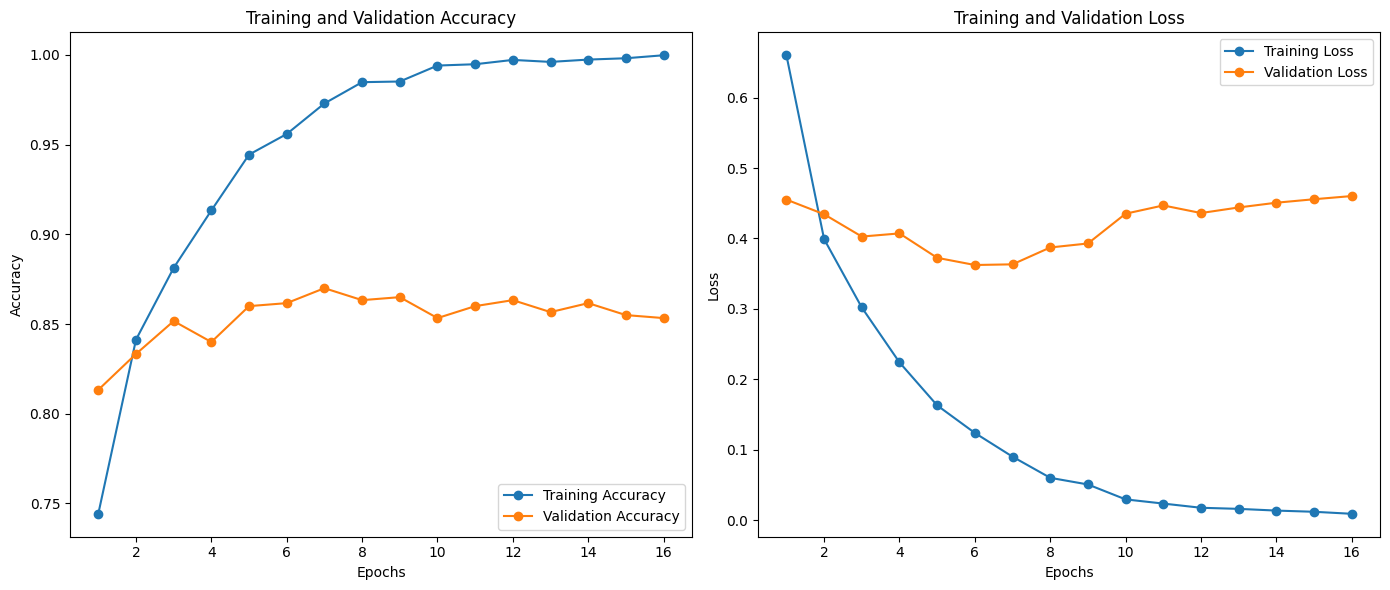

In [44]:
plot_history(fine_tune_history)

In [45]:
# Load the best model
model.load_weights('best_model.keras')
print("\nBest model loaded.")



Best model loaded.


In [46]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=BATCH_SIZE, verbose=1)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 378ms/step - accuracy: 0.8453 - loss: 0.3858

Test Accuracy: 0.8473
Test Loss: 0.3912


In [47]:
y_pred = model.predict(X_test, batch_size=BATCH_SIZE)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("\nClassification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=CLASSES_MERGED))

print("Confusion Matrix:")
print(confusion_matrix(y_true_labels, y_pred_labels))

47/47 ━━━━━━━━━━━━━━━━━━━━ 27s 305ms/step

Classification Report:
                        precision    recall  f1-score   support

          Non Demented       0.87      0.94      0.90       500
    Very mild Dementia       0.86      0.79      0.83       500
Mild+Moderate Dementia       0.81      0.81      0.81       500

              accuracy                           0.85      1500
             macro avg       0.85      0.85      0.85      1500
          weighted avg       0.85      0.85      0.85      1500

Confusion Matrix:
[[470   9  21]
 [ 29 396  75]
 [ 42  53 405]]


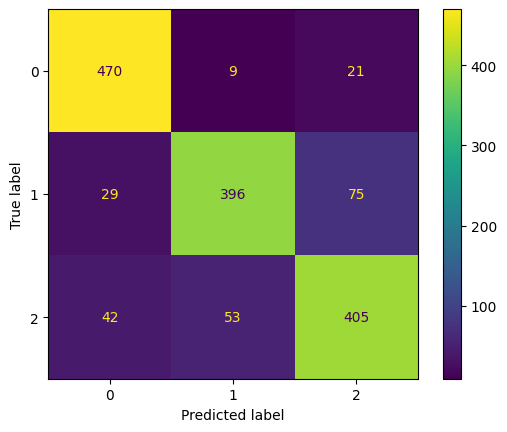

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cf = confusion_matrix(
    y_true=y_true_labels,
    y_pred=y_pred_labels
)

disp = ConfusionMatrixDisplay(confusion_matrix=cf)
disp.plot()


In [49]:
# Load and preprocess additional images
additional_X = []
for path in tqdm(valid_image_paths_additional, desc="Loading additional test images"):
    img = load_and_preprocess(path)
    if img is not None:
        additional_X.append(img)
additional_X = np.array(additional_X)
print("\nAdditional X shape:", additional_X.shape)

Loading additional test images: 100%|██████████| 1350/1350 [00:06<00:00, 202.18it/s]



Additional X shape: (1350, 299, 299, 3)


In [50]:
# Encode additional labels
y_int_additional = label_encoder.transform(labels_additional)
y_additional = ohe.transform(y_int_additional.reshape(-1,1))

In [51]:
# Predict on additional images
y_additional_pred = model.predict(additional_X, batch_size=1)
y_additional_pred_labels = np.argmax(y_additional_pred, axis=1)
y_additional_true_labels = np.argmax(y_additional, axis=1)


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step


In [52]:
# Classification report for additional testing
print("\nAdditional Testing Classification Report:")
print(classification_report(y_additional_true_labels, y_additional_pred_labels, target_names=CLASSES_MERGED))

print("Additional Testing Confusion Matrix:")
print(confusion_matrix(y_additional_true_labels, y_additional_pred_labels))


Additional Testing Classification Report:
                        precision    recall  f1-score   support

          Non Demented       0.86      0.94      0.90       450
    Very mild Dementia       0.86      0.83      0.84       450
Mild+Moderate Dementia       0.84      0.80      0.82       450

              accuracy                           0.86      1350
             macro avg       0.86      0.86      0.85      1350
          weighted avg       0.86      0.86      0.85      1350

Additional Testing Confusion Matrix:
[[425   9  16]
 [ 28 372  50]
 [ 41  51 358]]


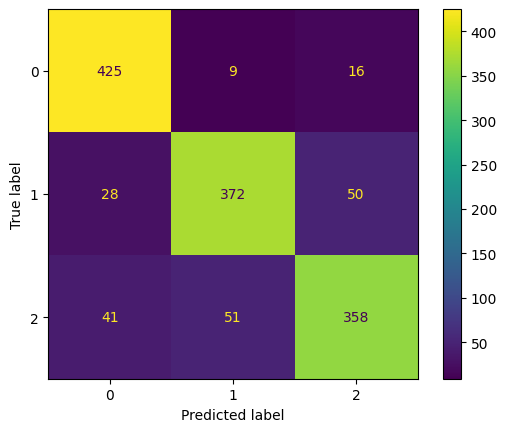

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cf = confusion_matrix(
    y_true=y_additional_true_labels,
    y_pred=y_additional_pred_labels
)

disp = ConfusionMatrixDisplay(confusion_matrix=cf)
disp.plot()


🔍 Grad-CAM Visualization for InceptionResNetV2 Alzheimer's Detection

📍 آخر طبقة Convolution: conv_7b_ac

🎨 تطبيق Grad-CAM على عينات من بيانات الاختبار...
------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_790']]
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_790']]
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_790']]
Received: inputs=Tensor(shape=(1, 299, 299, 3))
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_790']]
Received: inputs=Tensor(shape=(1, 299, 299, 3))
 

ValueError: num must be an integer with 1 <= num <= 20, not 21

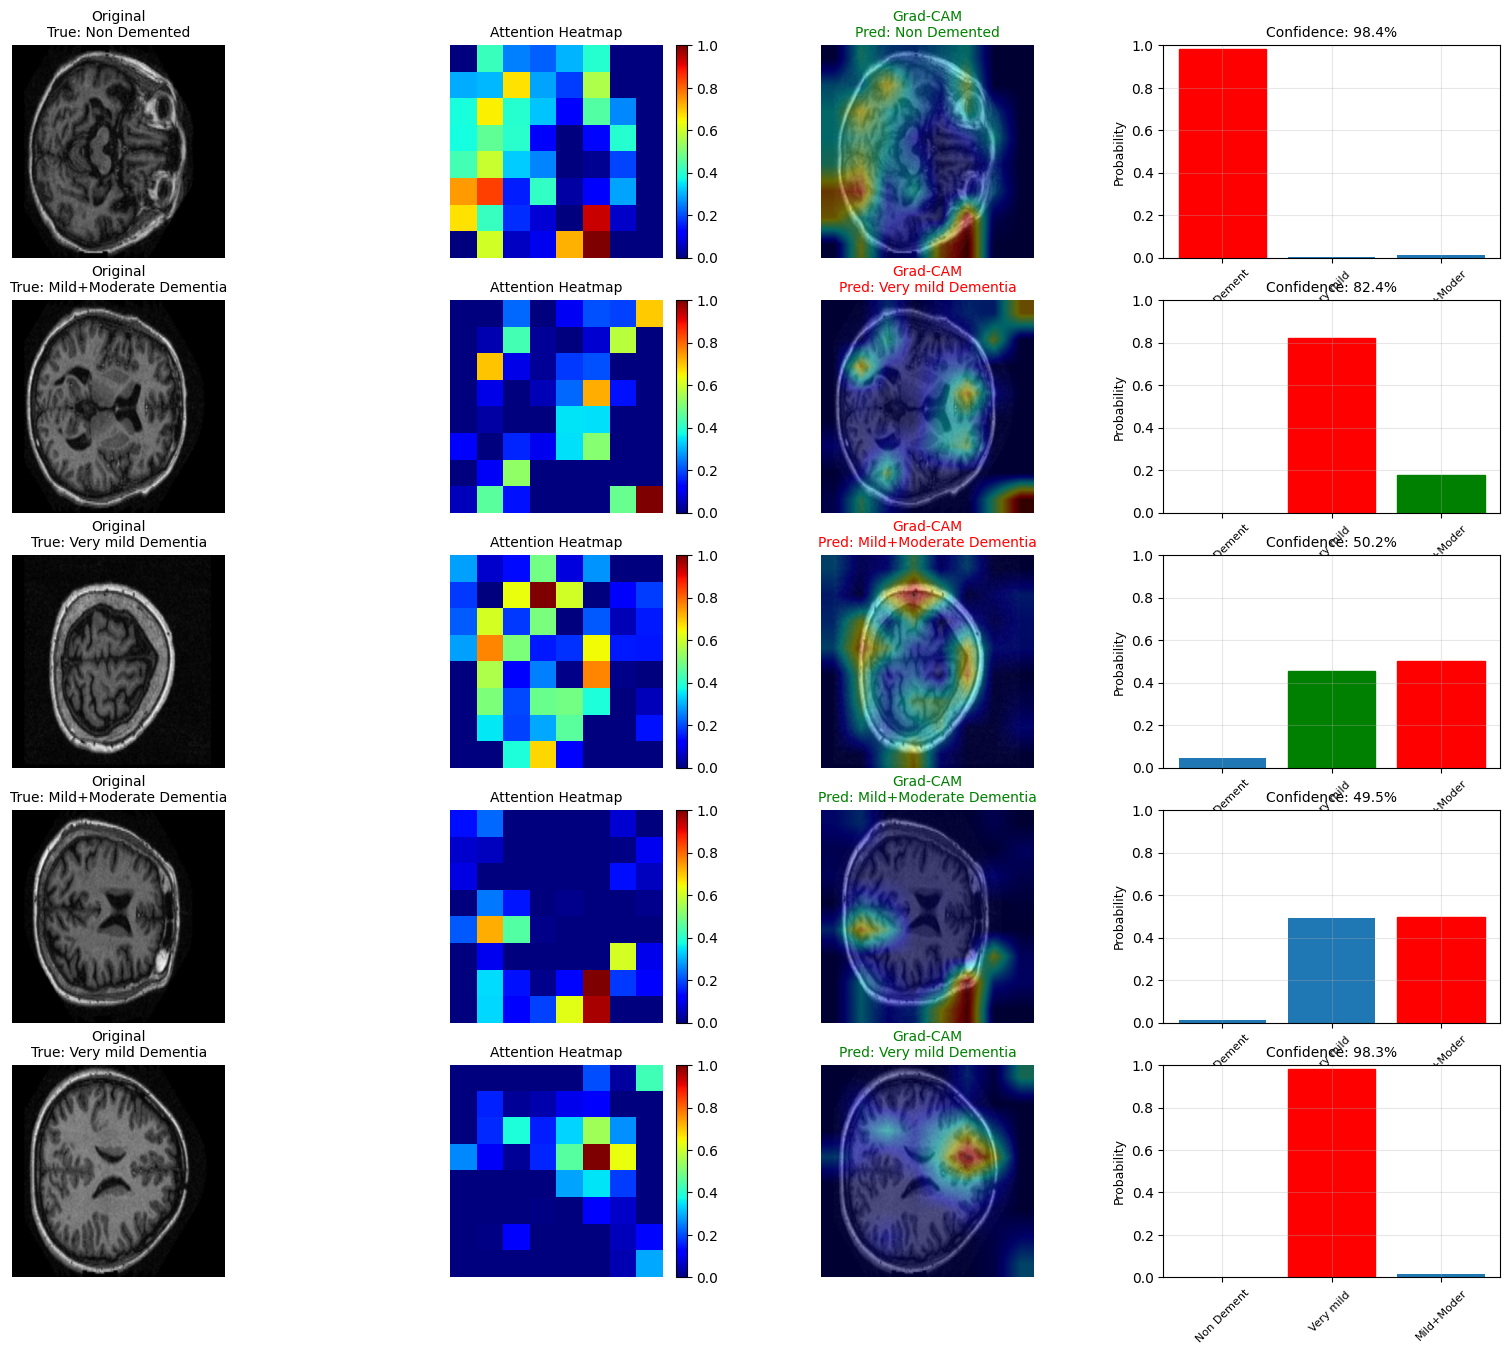

In [60]:
"""
Grad-CAM Visualization for InceptionResNetV2 Alzheimer's Model
"""

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.models import Model
import cv2

print("="*80)
print("🔍 Grad-CAM Visualization for InceptionResNetV2 Alzheimer's Detection")
print("="*80)

# ==========================================
# 1. دوال Grad-CAM الأساسية
# ==========================================

import numpy as np, cv2

def _ensure_numpy_2d(heatmap):
    # إلى numpy و 2D مع تنظيف NaN/Inf وتطبيع 0..1
    import tensorflow as tf
    if isinstance(heatmap, tf.Tensor):
        heatmap = heatmap.numpy()
    heatmap = np.squeeze(heatmap)
    if heatmap.ndim == 3:
        heatmap = heatmap[..., 0]
    if heatmap.ndim != 2:
        raise ValueError(f"Bad heatmap ndim={heatmap.ndim}, shape={heatmap.shape}")
    heatmap = np.nan_to_num(heatmap, nan=0.0, posinf=0.0, neginf=0.0).astype('float32')
    if heatmap.size == 0 or min(heatmap.shape) < 2:
        raise ValueError(f"Bad heatmap shape={heatmap.shape}")
    m = heatmap.max()
    if m > 0:
        heatmap /= m
    return heatmap

def _ensure_uint8_rgb(img):
    # يحول أي صورة إلى RGB uint8
    if not isinstance(img, np.ndarray):
        img = np.array(img)
    if img.ndim == 2:
        img = np.stack([img, img, img], axis=-1)
    img = img.astype('float32')
    if img.max() <= 1.0:  # من [0,1] إلى [0,255]
        img = img * 255.0
    img = np.clip(img, 0, 255).astype('uint8')
    return img

def superimpose_gradcam(img, heatmap, alpha=0.4):
    img = _ensure_uint8_rgb(img)
    hm = _ensure_numpy_2d(heatmap)

    # Resize + colormap (BGR)
    hm = cv2.resize(hm, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_LINEAR)
    hm_color = cv2.applyColorMap((hm * 255).astype('uint8'), cv2.COLORMAP_JET)

    # اضمن أن المزج يكون بـ BGR ثم رجّع RGB للعرض بـ matplotlib
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    overlay_bgr = cv2.addWeighted(hm_color, alpha, img_bgr, 1 - alpha, 0)
    overlay_rgb = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)
    return overlay_rgb


# ==========================================
# 2. العثور على آخر طبقة Convolution في InceptionResNetV2
# ==========================================

def get_last_conv_layer_name(model):
    """
    العثور على آخر طبقة convolution في InceptionResNetV2
    عادة تكون 'conv_7b_ac' أو مشابه
    """
    for layer in reversed(model.layers):
        if 'conv' in layer.name.lower():
            return layer.name

    # إذا لم نجد، نبحث في base_model
    if hasattr(model, 'layers'):
        for layer in reversed(model.layers[0].layers):  # base_model layers
            if 'conv' in layer.name.lower():
                return layer.name

    return None

# الحصول على اسم آخر طبقة convolution
last_conv_layer = get_last_conv_layer_name(model)
print(f"\n📍 آخر طبقة Convolution: {last_conv_layer}")

if last_conv_layer is None:
    # محاولة يدوية للعثور على الطبقة في InceptionResNetV2
    last_conv_layer = 'conv_7b_ac'  # الطبقة الأخيرة في InceptionResNetV2
    print(f"⚠️ استخدام الطبقة الافتراضية: {last_conv_layer}")

# ==========================================
# 3. تطبيق Grad-CAM على عينات من بيانات الاختبار
# ==========================================

print("\n🎨 تطبيق Grad-CAM على عينات من بيانات الاختبار...")
print("-"*60)

# اختيار عينات عشوائية
num_samples = 12
indices = np.random.choice(len(X_test), min(num_samples, len(X_test)), replace=False)

# إنشاء figure كبير
fig = plt.figure(figsize=(20, 4*len(indices)//3))

for idx, i in enumerate(indices):
    # الصورة الأصلية
    img = X_test[i].copy()
    true_label = np.argmax(y_test[i])

    # إلغاء المعالجة المسبقة للعرض
    # InceptionResNetV2 uses [-1, 1] range, convert back to [0, 1]
    img_display = (img + 1.0) / 2.0
    img_display = np.clip(img_display, 0, 1)

    # التنبؤ
    img_array = np.expand_dims(img, axis=0)
    preds = model.predict(img_array, verbose=0)
    pred_class = np.argmax(preds[0])
    confidence = preds[0][pred_class] * 100

    # حساب Grad-CAM
    try:
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer, pred_class)
    except Exception as e:
        print(f"⚠️ خطأ في Grad-CAM للصورة {i}: {e}")
        continue

    # عرض النتائج (4 أعمدة)
    # 1. الصورة الأصلية
    plt.subplot(len(indices)//3 + 1, 4, idx*4 + 1)
    plt.imshow(img_display)
    plt.title(f'Original\nTrue: {CLASSES_MERGED[true_label]}', fontsize=10)
    plt.axis('off')

    # 2. Heatmap
    plt.subplot(len(indices)//3 + 1, 4, idx*4 + 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title('Attention Heatmap', fontsize=10)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('off')

    # 3. Grad-CAM overlay
    plt.subplot(len(indices)//3 + 1, 4, idx*4 + 3)
    gradcam_img = superimpose_gradcam(img_display, heatmap, alpha=0.4)
    plt.imshow(gradcam_img)

    # اللون حسب صحة التنبؤ
    color = 'green' if pred_class == true_label else 'red'
    plt.title(f'Grad-CAM\nPred: {CLASSES_MERGED[pred_class]}', fontsize=10, color=color)
    plt.axis('off')

    # 4. توزيع الاحتماليات
    plt.subplot(len(indices)//3 + 1, 4, idx*4 + 4)
    bars = plt.bar(range(len(CLASSES_MERGED)), preds[0])
    bars[pred_class].set_color('red')
    if pred_class != true_label:
        bars[true_label].set_color('green')
    plt.xticks(range(len(CLASSES_MERGED)), [c[:10] for c in CLASSES_MERGED], rotation=45, fontsize=8)
    plt.ylabel('Probability', fontsize=9)
    plt.title(f'Confidence: {confidence:.1f}%', fontsize=10)
    plt.ylim([0, 1])
    plt.grid(True, alpha=0.3)

plt.suptitle('Grad-CAM Analysis - InceptionResNetV2 Alzheimer\'s Detection', fontsize=16, y=1.001)
plt.tight_layout()
plt.savefig('gradcam_inceptionresnet_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ تم حفظ التحليل في: gradcam_inceptionresnet_analysis.png")

# ==========================================
# 4. تحليل متوسط مناطق التركيز لكل فئة
# ==========================================

print("\n📊 تحليل متوسط مناطق التركيز لكل فئة...")
print("-"*60)

# تجميع heatmaps لكل فئة
class_heatmaps = {i: [] for i in range(len(CLASSES_MERGED))}
samples_per_class = 25  # عدد العينات لكل فئة

for class_idx in range(len(CLASSES_MERGED)):
    # العثور على عينات من هذه الفئة
    class_indices = np.where(np.argmax(y_test, axis=1) == class_idx)[0]

    # اختيار عينات عشوائية
    selected_indices = np.random.choice(
        class_indices,
        min(samples_per_class, len(class_indices)),
        replace=False
    )

    print(f"معالجة {len(selected_indices)} صورة لفئة {CLASSES_MERGED[class_idx]}...")

    for idx in selected_indices:
        img = X_test[idx]
        img_array = np.expand_dims(img, axis=0)

        try:
            # حساب heatmap
            heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer, class_idx)
            class_heatmaps[class_idx].append(heatmap)
        except:
            continue

# عرض متوسط heatmap لكل فئة
fig, axes = plt.subplots(1, len(CLASSES_MERGED), figsize=(16, 4))

for class_idx in range(len(CLASSES_MERGED)):
    if len(class_heatmaps[class_idx]) > 0:
        # حساب المتوسط
        avg_heatmap = np.mean(class_heatmaps[class_idx], axis=0)

        # عرض
        im = axes[class_idx].imshow(avg_heatmap, cmap='jet')
        axes[class_idx].set_title(f'{CLASSES_MERGED[class_idx]}\n({len(class_heatmaps[class_idx])} samples)',
                                 fontsize=11)
        axes[class_idx].axis('off')

        # إضافة colorbar
        plt.colorbar(im, ax=axes[class_idx], fraction=0.046, pad=0.04)

plt.suptitle('Average Attention Regions by Class - InceptionResNetV2', fontsize=14)
plt.tight_layout()
plt.savefig('average_attention_by_class_inception.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ تم حفظ تحليل المناطق في: average_attention_by_class_inception.png")

# ==========================================
# 5. تحليل الأخطاء باستخدام Grad-CAM
# ==========================================

print("\n🔍 تحليل الأخطاء في التصنيف...")
print("-"*60)

# العثور على التنبؤات الخاطئة
y_pred_test = model.predict(X_test, verbose=0)
y_pred_labels = np.argmax(y_pred_test, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# العثور على الأخطاء
misclassified_indices = np.where(y_pred_labels != y_true_labels)[0]
print(f"عدد الأخطاء: {len(misclassified_indices)} من {len(X_test)}")

if len(misclassified_indices) > 0:
    # عرض بعض الأخطاء مع Grad-CAM
    num_errors_to_show = min(8, len(misclassified_indices))
    error_indices = np.random.choice(misclassified_indices, num_errors_to_show, replace=False)

    fig = plt.figure(figsize=(16, 3*num_errors_to_show))

    for idx, error_idx in enumerate(error_indices):
        img = X_test[error_idx].copy()
        true_label = y_true_labels[error_idx]
        pred_label = y_pred_labels[error_idx]

        # إلغاء المعالجة للعرض
        img_display = (img + 1.0) / 2.0
        img_display = np.clip(img_display, 0, 1)

        # Grad-CAM
        img_array = np.expand_dims(img, axis=0)
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer, pred_label)

        # عرض
        # 1. الصورة الأصلية
        plt.subplot(num_errors_to_show, 3, idx*3 + 1)
        plt.imshow(img_display)
        plt.title(f'True: {CLASSES_MERGED[true_label]}', fontsize=10, color='green')
        plt.axis('off')

        # 2. Heatmap
        plt.subplot(num_errors_to_show, 3, idx*3 + 2)
        plt.imshow(heatmap, cmap='jet')
        plt.title('Focus Area', fontsize=10)
        plt.axis('off')

        # 3. Grad-CAM
        plt.subplot(num_errors_to_show, 3, idx*3 + 3)
        gradcam_img = superimpose_gradcam(img_display, heatmap)
        plt.imshow(gradcam_img)
        confidence = y_pred_test[error_idx][pred_label] * 100
        plt.title(f'Pred: {CLASSES_MERGED[pred_label]}\n({confidence:.1f}%)',
                 fontsize=10, color='red')
        plt.axis('off')

    plt.suptitle('Misclassification Analysis with Grad-CAM', fontsize=14)
    plt.tight_layout()
    plt.savefig('misclassification_gradcam_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✅ تم حفظ تحليل الأخطاء في: misclassification_gradcam_analysis.png")

# ==========================================
# 6. دالة للتحليل التفاعلي
# ==========================================

def analyze_single_image_gradcam(image_array, true_label=None):


    # التنبؤ
    img_batch = np.expand_dims(image_array, axis=0)
    predictions = model.predict(img_batch, verbose=0)
    pred_class = np.argmax(predictions[0])
    confidence = predictions[0][pred_class] * 100

    # Grad-CAM
    heatmap = make_gradcam_heatmap(img_batch, model, last_conv_layer, pred_class)

    # إلغاء المعالجة للعرض
    img_display = (image_array + 1.0) / 2.0
    img_display = np.clip(img_display, 0, 1)

    # عرض النتائج
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))

    # 1. الصورة الأصلية
    axes[0].imshow(img_display)
    title = 'Original Image'
    if true_label is not None:
        title += f'\nTrue: {CLASSES_MERGED[true_label]}'
    axes[0].set_title(title, fontsize=11)
    axes[0].axis('off')

    # 2. Heatmap
    im = axes[1].imshow(heatmap, cmap='jet')
    axes[1].set_title('Attention Heatmap', fontsize=11)
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046)

    # 3. Grad-CAM
    gradcam = superimpose_gradcam(img_display, heatmap)
    axes[2].imshow(gradcam)
    color = 'green' if true_label == pred_class else 'red' if true_label is not None else 'black'
    axes[2].set_title(f'Grad-CAM\nPred: {CLASSES_MERGED[pred_class]}', fontsize=11, color=color)
    axes[2].axis('off')

    # 4. احتماليات
    axes[3].bar(range(len(CLASSES_MERGED)), predictions[0])
    axes[3].set_xticks(range(len(CLASSES_MERGED)))
    axes[3].set_xticklabels([c[:8] for c in CLASSES_MERGED], rotation=45)
    axes[3].set_ylabel('Probability')
    axes[3].set_title(f'Confidence: {confidence:.1f}%', fontsize=11)
    axes[3].set_ylim([0, 1])
    axes[3].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return pred_class, confidence, heatmap

# مثال على الاستخدام
print("\n" + "="*80)
print("✅ Grad-CAM Analysis Complete!")
print("="*80)




🎨 تطبيق Grad-CAM على عينات من بيانات الاختبار...
------------------------------------------------------------
📍 آخر طبقة Convolution: conv_7b_ac


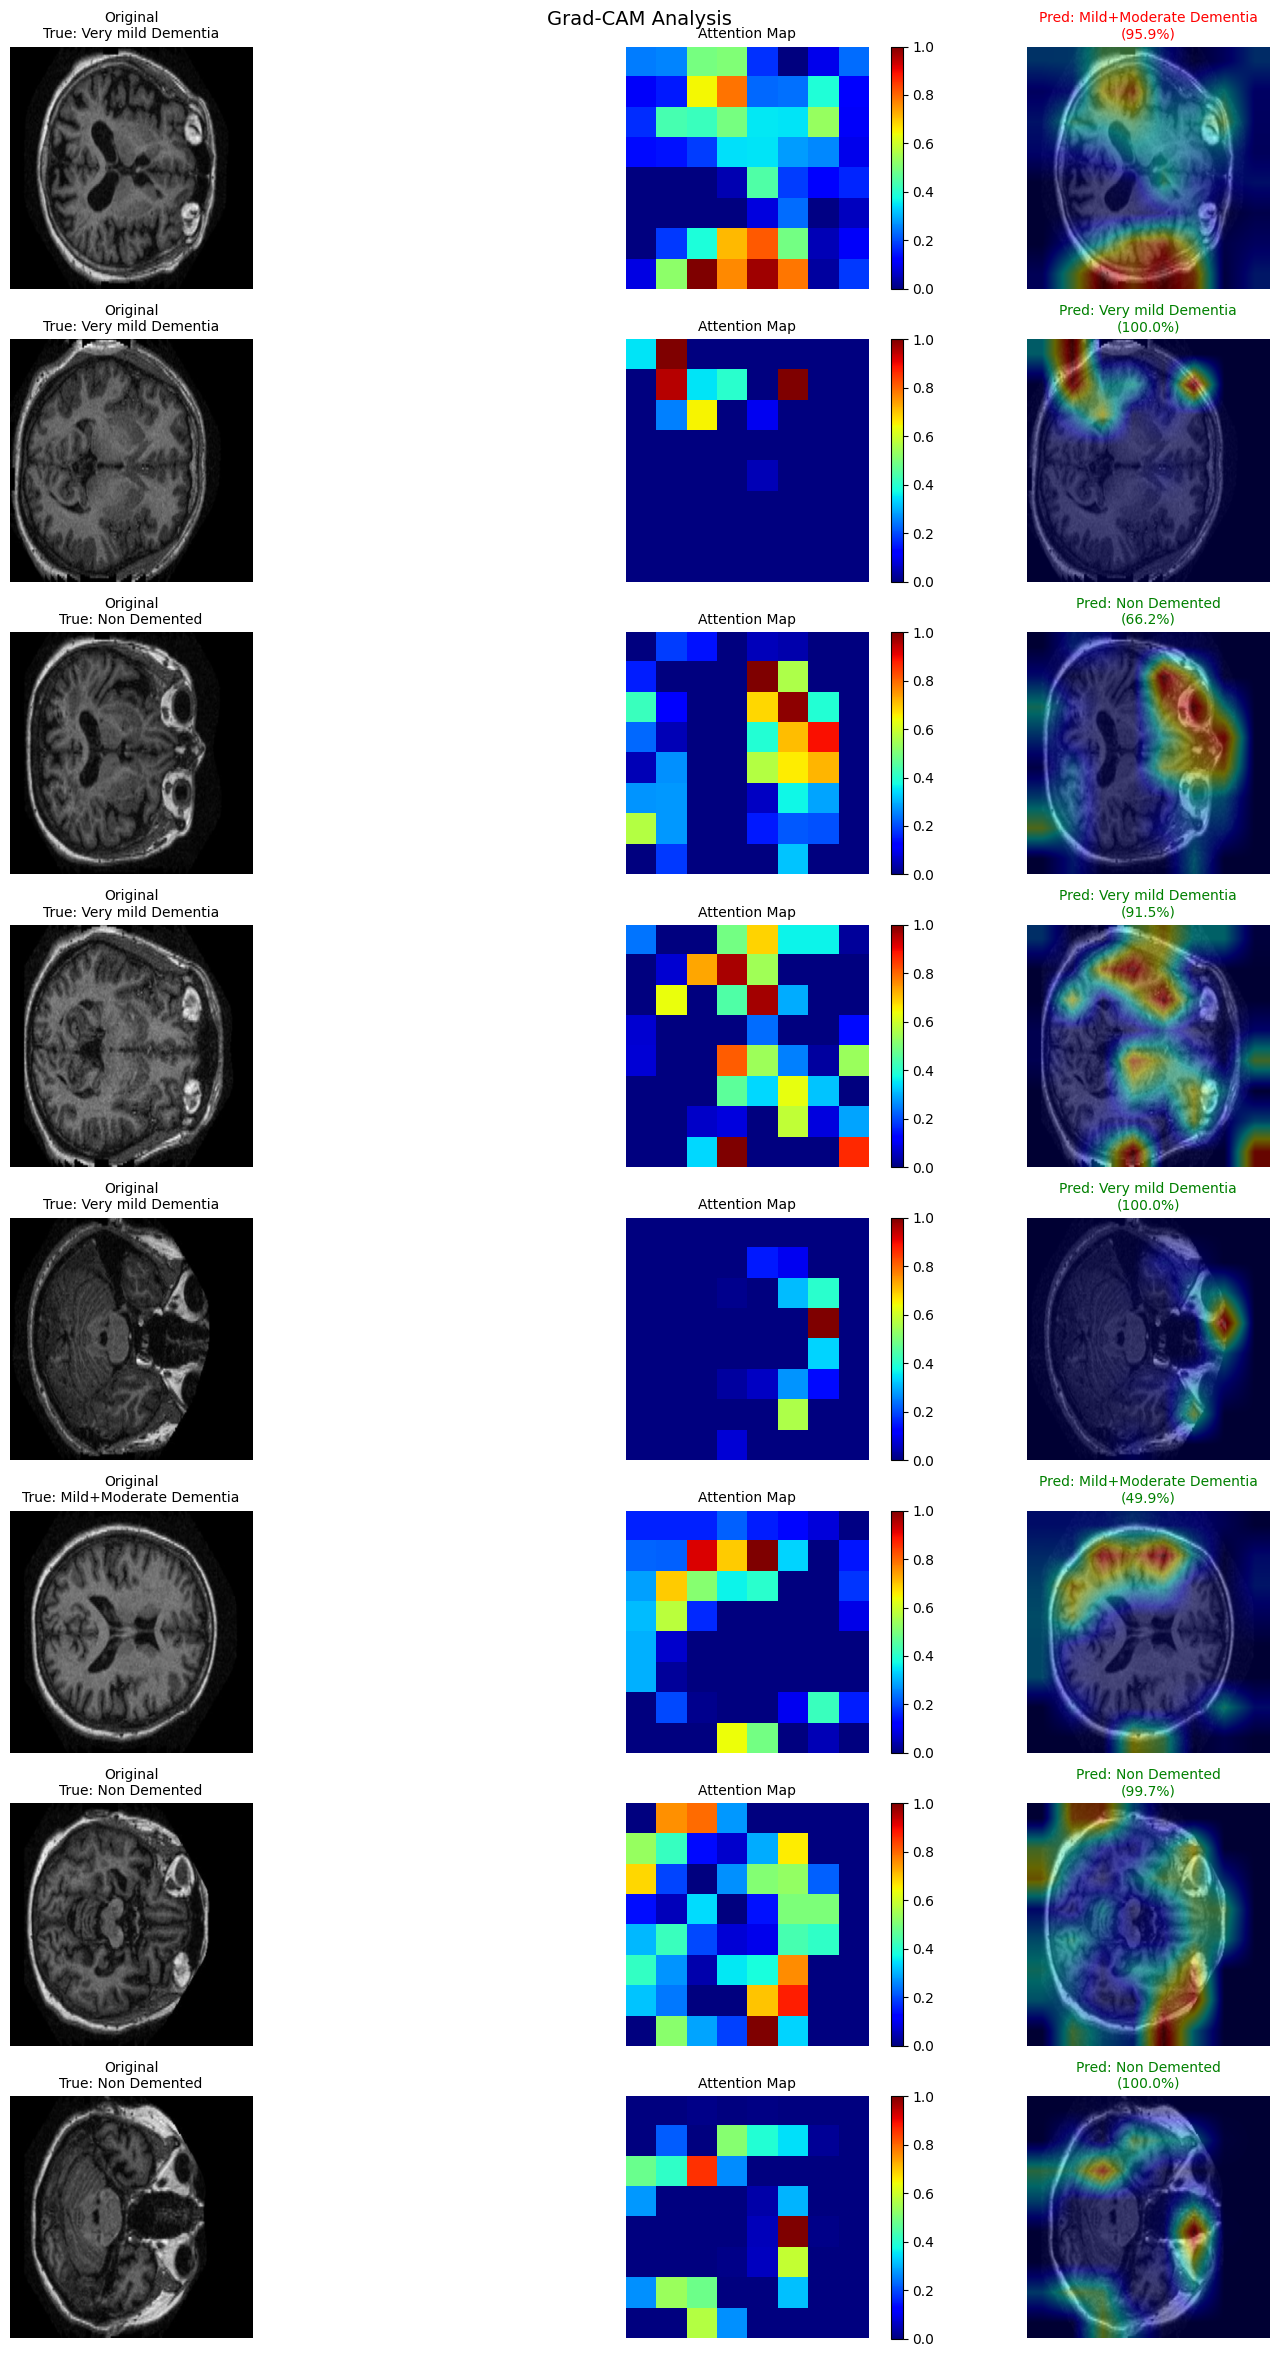

✅ تم حفظ التحليل في: gradcam_analysis.png


In [61]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# تطبيق Grad-CAM على عينات
print("\n🎨 تطبيق Grad-CAM على عينات من بيانات الاختبار...")
print("-"*60)

# العثور على آخر طبقة convolution
def get_last_conv_layer_name(model):
    for layer in reversed(model.layers):
        if 'conv' in layer.name.lower():
            return layer.name
    # للنماذج المعقدة، ابحث في الطبقات الداخلية
    if hasattr(model.layers[0], 'layers'):
        for layer in reversed(model.layers[0].layers):
            if 'conv' in layer.name.lower():
                return layer.name
    return 'conv_7b_ac'  # الافتراضي لـ InceptionResNetV2

last_conv_layer = get_last_conv_layer_name(model)
print(f"📍 آخر طبقة Convolution: {last_conv_layer}")

# اختيار عينات
num_samples = min(8, len(X_test))
indices = np.random.choice(len(X_test), num_samples, replace=False)

# إنشاء figure
fig = plt.figure(figsize=(16, 3*num_samples))

for idx, i in enumerate(indices):
    img = X_test[i].copy()
    true_label = np.argmax(y_test[i])

    # إلغاء المعالجة للعرض
    img_display = (img + 1.0) / 2.0
    img_display = np.clip(img_display, 0, 1)

    # التنبؤ
    img_array = np.expand_dims(img, axis=0)
    preds = model.predict(img_array, verbose=0)
    pred_class = np.argmax(preds[0])
    confidence = preds[0][pred_class] * 100

    # حساب Grad-CAM
    try:
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer, pred_class)
    except Exception as e:
        print(f"⚠️ خطأ في Grad-CAM للصورة {i}: {e}")
        continue

    # 1. الصورة الأصلية
    plt.subplot(num_samples, 3, idx*3 + 1)
    plt.imshow(img_display)
    plt.title(f'Original\nTrue: {CLASSES_MERGED[true_label]}', fontsize=10)
    plt.axis('off')

    # 2. Heatmap
    plt.subplot(num_samples, 3, idx*3 + 2)
    plt.imshow(heatmap, cmap='jet')
    plt.title('Attention Map', fontsize=10)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis('off')

    # 3. Grad-CAM overlay
    plt.subplot(num_samples, 3, idx*3 + 3)
    gradcam_img = superimpose_gradcam(img_display, heatmap, alpha=0.4)
    plt.imshow(gradcam_img)

    color = 'green' if pred_class == true_label else 'red'
    plt.title(f'Pred: {CLASSES_MERGED[pred_class]}\n({confidence:.1f}%)',
             fontsize=10, color=color)
    plt.axis('off')

plt.suptitle('Grad-CAM Analysis', fontsize=14)
plt.tight_layout()
plt.savefig('gradcam_analysis.png', dpi=100, bbox_inches='tight')
plt.show()

print("✅ تم حفظ التحليل في: gradcam_analysis.png")